# Определение стоимости автомобилей

### Вводная <a class="tocSkip">

Платформа по продаже автомобилей "AB-и-ТО" хочет дать возможнсть своим клиентам быстро узнать рыночную стоимость своего автомобиля. Для построения модели вам предоставили датасет объявлений, который содержит информацию о технических характеристиках, датах активности пользователя и ценах на автомобили.  

При выборе модели необходимо рассмотреть:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Цель <a class="tocSkip">
    Построить модель для определения рыночной стоимости автомобиля по его признакам.

### Описание данных <a class="tocSkip">

Данные находятся в файле /datasets/autos.csv.

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
  Целевой признак
  
    Price — цена (евро)

### План <a class="tocSkip">

    
    1. Подготовка данных  
         1.1. Загрузка файлов и получение информации.  
         1.2. Предобработка данных.  
    2. Исследовательский анализ данных  
         2.1. Распределения признаков. Оценка аномальных значений.
         2.2. Оценка корреляции признаков.
    3. Построение моделей  
         3.1. Выбор метрики для оценки качества моделей.  
         3.2. Обучение моделей и оценка их качества кросс-валидацией. 
    4. Анализ моделей 
         4.1. Проверка лучшей модели на тестовой выборке.
         4.2. Проверка лучшей модели на адеватность.
         4.3. Сравнение характеристик моделей: скорость работы и качество предсказаний.
    5. Общий вывод   

## 0. Установка библиотек <a class="tocSkip">

In [2]:
%%capture

%pip install --upgrade ipykernel
%pip install seaborn>=0.11 -U
%pip install scikit-learn -U
%pip install dill

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: ipykernel in /home/jovyan/.local/lib/python3.7/site-packages (5.5.5)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.2)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import dill

from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import scipy.stats as ss

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import (make_scorer, 
                            mean_squared_error as mse,
                            mean_absolute_error as mae)

import lightgbm as lgb

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

#фильтр предупреждений
import warnings
warnings.simplefilter("ignore")

In [4]:
#зададим ramdom seed
RS = 2021

## Подготовка данных

### Загрузка файлов и получение информации

In [5]:
#сделаем парсер для колонок с датой
my_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [6]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'],
                date_parser=my_date_parser)

data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


В данных всего 354369 объявлений. В 5и строках есть пропуски. Также можно заметить нулевое значение мощности у 1й записи. Нулевого значения здесь быть не может, поэтому будем смотреть что делать с такими объявлениями.

### Предобработка данных

#### Проверка дубликатов:

In [8]:
data.duplicated().sum()

4

Так как это полные дубликаты где совпадает даже время, то они скорее всего появляются при создании финального датасета, например при склеивании таблиц. Удалим дубликаты.

In [9]:
data.drop_duplicates(keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)

data.duplicated().sum()

0

#### Кодировка признаков

Послкольку мы работаем с категориальными данными, нам необходимо провести кодировку признаков в численный вид.

Можно использовать one-hot encoding или ordinal encoding.
Какой из них выбрать? 
 - one-hot encoding будет занимать больше оперативной памяти и модели будут медленее работать. 
 - ordinal encoding будет занимать мало памяти, однако с ним будет плохо работать модель линейной регресии (т.к. она не умеет отличать категориальные переменные от числовых)
 
Посмотрим на количество категорий в признаках:

In [10]:
data.nunique()

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Во-первых, мы видим странные значения в признаках:
 - RegistrationMonth - месяцов всего 12, а не 13;
 - Kilometer - очень малая вариативность значений; скорее всего это связано с тем, что значение синтетическое.
 - FuelType - много различных видов топлива, нужно их проверить;
 - NumberOfPictures - всего одно значение и это 0. 

Во-второых, становится видно, что в некоторых, на наш взгляд важных, переменных есть очень много разных категорий. Например в признаке "Модель" их целых 250. Помимо того что мы создадим очень большое количество дополнительных стлбцов с признаками, когда категорий очень много, при OHE могут возникнуть многочисленные dummy-ловушки, которые мы можем не отследить. Поэтому в данной ситуации будем использовать Ordinal encoding.

#### Анализ значений

In [11]:
data["RegistrationMonth"].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [12]:
data[data['RegistrationMonth'] == 0 ]['RegistrationMonth'].count()

37352

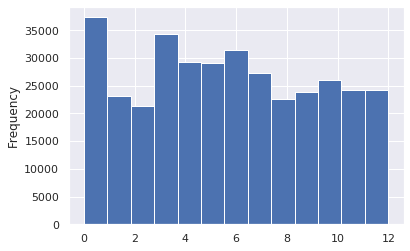

In [13]:
data['RegistrationMonth'].plot(kind = 'hist', bins = 13)

Появляется нулевой месяц. В целом можно сказать что 0 появляются примерно также как и остальные месяца. Есть два возможных объяснения: 1. этот признак сформирован автоматически, при его формировании случайно добавили "нулевой месяц"; 2. так записывали пропущенные значения. Поскольку признаки категориальные, можем оставить все как есть, работу моделей это не изменит, информацию можно будет получить.

In [14]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

В целом список реалистичный. 

In [15]:
data['NumberOfPictures'].unique()

array([0])

Этот признак состоит только из нулей. Скорее всего эти данные были потеряны при формировании датасета. Поскольку эти данные мы восстановить никак не можем, признак придется удалить. 

In [16]:
data.drop(['NumberOfPictures'], axis=1, inplace=True)

#### Ordinal encoding

Сделаем список категориальных переменных. Это VehicleType, Gearbox, Model, RegistrationMonth, FuelType, Brand, NotRepaired.

In [17]:
categorical_features = ["VehicleType", "Gearbox", "Model", "RegistrationMonth", "FuelType", "Brand", "NotRepaired"]

In [18]:
encoder = OrdinalEncoder()

def encode(data):
    real_data = np.array(data.dropna())
    impute_reshape = real_data.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

for column in categorical_features:
    encode(data[column])
    
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,1,0,116,150000,0.0,6,38,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,2,2011,1,190,NaN,125000,5.0,2,1,1,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,6,2004,0,163,117,125000,8.0,2,14,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,5,2001,1,75,116,150000,6.0,6,38,0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,5,2008,1,69,101,90000,7.0,2,31,0,2016-03-31,60437,2016-04-06 10:17:21


Признаки закодированы.

####  Обработка пропусков

In [19]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

`VehicleType`

VehicleType - тип автомобильного кузова. Если подумать логически, то вообще вся информация о типе кузова уже содержится в признаке `Model` – модель автомобиля описывает его внешний вид и кузов. 
Как известно, коллинеарные признаки уходшают работу моделей. Поэтому мы считаем что можно сразу сделать небольшой feature engineering и удалить этот признак.

Заполнять пропуски будем помощью KNNImputer, который заполняет значения по n ближайшим соседям.
Заполнение будем оценивать по признаку `NotRepaired`, где самое большое количество пропусков.          

Спрячем наши признаки, содержащие дату, целевой признак (чтобы избежать утечки данных), а также почтовый адрес клиента.

In [20]:
drop_columns = ['DateCrawled', 'Price', 'DateCreated', 'PostalCode', 'LastSeen']
data_4_imputation = data.drop(drop_columns, axis=1)

In [21]:
small_data = data_4_imputation.iloc[0:30000, :]
small_data.head(3)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,NaN,1993,1,0,116,150000,0.0,6,38,NaN
1,2,2011,1,190,NaN,125000,5.0,2,1,1
2,6,2004,0,163,117,125000,8.0,2,14,NaN


In [22]:
%%time

#проведем замену
temp_data = small_data
imputer = KNNImputer(n_neighbors=3)

encode_data = pd.DataFrame(np.round(imputer.fit_transform(temp_data)), columns = temp_data.columns)

CPU times: user 30.6 s, sys: 7.4 s, total: 38 s
Wall time: 38.6 s


KNNImputer с таким объемом данных справляется тяжело, поскольку у него квадратичная сложность. Уже на 30т. строк время работы около 36 секунд. Можно попробовать заполнить пропуски batch-ами, разделив выборку на несколько.

In [23]:
data_4_imputation.shape

(354365, 10)

In [24]:
%%time

#создадим пустой df
imputed_data = pd.DataFrame(columns = data_4_imputation.columns)

imputer = KNNImputer(n_neighbors=5)

n_batches = 57 
batch_size = int(np.ceil(len(data_4_imputation) / n_batches))
print('Batch size:', batch_size)

for batch_n in tqdm(range(0, n_batches)):
    begin = batch_n * batch_size
    end = (batch_n + 1) * batch_size
    batch_of_data = data_4_imputation.iloc[begin:end, :]
    imputed_batch = pd.DataFrame(np.round(imputer.fit_transform(batch_of_data)), columns = data_4_imputation.columns)
    imputed_data = imputed_data.append(imputed_batch, ignore_index=True)
    
imputed_data.info()

  0%|          | 0/57 [00:00<?, ?it/s]

Batch size: 6217


100%|██████████| 57/57 [01:59<00:00,  2.10s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
VehicleType          354365 non-null float64
RegistrationYear     354365 non-null float64
Gearbox              354365 non-null float64
Power                354365 non-null float64
Model                354365 non-null float64
Kilometer            354365 non-null float64
RegistrationMonth    354365 non-null float64
FuelType             354365 non-null float64
Brand                354365 non-null float64
NotRepaired          354365 non-null float64
dtypes: float64(10)
memory usage: 27.0 MB
CPU times: user 1min 32s, sys: 26.6 s, total: 1min 59s
Wall time: 1min 59s


Размерность сохранилась, просмотрим получившиеся таблицы:

In [25]:
data_4_imputation

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,NaN,1993,1,0,116,150000,0.0,6,38,NaN
1,2,2011,1,190,NaN,125000,5.0,2,1,1
2,6,2004,0,163,117,125000,8.0,2,14,NaN
3,5,2001,1,75,116,150000,6.0,6,38,0
4,5,2008,1,69,101,90000,7.0,2,31,0
...,...,...,...,...,...,...,...,...,...,...
354360,NaN,2005,1,0,78,150000,7.0,6,22,1
354361,NaN,2005,NaN,0,NaN,20000,1.0,NaN,33,NaN
354362,1,2000,0,101,106,125000,3.0,6,32,0
354363,0,1996,1,102,224,150000,3.0,2,38,0


In [26]:
imputed_data

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,4.0,1993.0,1.0,0.0,116.0,150000.0,0.0,6.0,38.0,0.0
1,2.0,2011.0,1.0,190.0,43.0,125000.0,5.0,2.0,1.0,1.0
2,6.0,2004.0,0.0,163.0,117.0,125000.0,8.0,2.0,14.0,0.0
3,5.0,2001.0,1.0,75.0,116.0,150000.0,6.0,6.0,38.0,0.0
4,5.0,2008.0,1.0,69.0,101.0,90000.0,7.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
354360,3.0,2005.0,1.0,0.0,78.0,150000.0,7.0,6.0,22.0,1.0
354361,4.0,2005.0,1.0,0.0,154.0,20000.0,1.0,4.0,33.0,0.0
354362,1.0,2000.0,0.0,101.0,106.0,125000.0,3.0,6.0,32.0,0.0
354363,0.0,1996.0,1.0,102.0,224.0,150000.0,3.0,2.0,38.0,0.0


Пропуски заполнились, проверим изменились ли распределения:

`NotRepaired`

In [27]:
data['NotRepaired'].value_counts()[1] / data['NotRepaired'].value_counts()[0]

0.14587025303651915

In [28]:
imputed_data['NotRepaired'].value_counts()[1] / imputed_data['NotRepaired'].value_counts()[0]

0.13114827358361078

Отношение изменилось на 1.5%. В целом это хороший результат для заполнения.

`FuelType`

In [29]:
data['FuelType'].nunique()

7

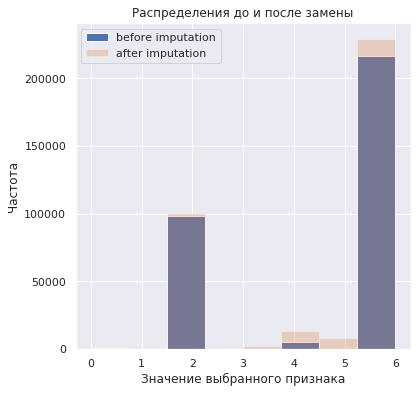

In [30]:
#создадим график до замены
ax = data['FuelType'].plot(kind = 'hist', bins = 8, label= 'before imputation')
mean_before = data['FuelType'].mean()

#создадим график после замены
imputed_data['FuelType'].plot(ax = ax, 
                                alpha = 0.3,
                                kind = 'hist', 
                                label= 'after imputation', 
                                bins = 8,
                                figsize =(6, 6),
                                grid = True)

plt.xlabel('Значение выбранного признака')
plt.ylabel('Частота')
plt.title('Распределения до и после замены')
plt.legend(loc='upper left');

Можно сказать что визуально распределения похожи. Поскольку это категориальные переменные, среднее и дисперсию считать смысла нет. Будем считать что заполнение проведено успешно.

In [31]:
data['Price'].shape, imputed_data.shape

((354365,), (354365, 10))

In [32]:
imputed_data = imputed_data.join(data['Price'])
imputed_data

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,Price
0,4.0,1993.0,1.0,0.0,116.0,150000.0,0.0,6.0,38.0,0.0,480
1,2.0,2011.0,1.0,190.0,43.0,125000.0,5.0,2.0,1.0,1.0,18300
2,6.0,2004.0,0.0,163.0,117.0,125000.0,8.0,2.0,14.0,0.0,9800
3,5.0,2001.0,1.0,75.0,116.0,150000.0,6.0,6.0,38.0,0.0,1500
4,5.0,2008.0,1.0,69.0,101.0,90000.0,7.0,2.0,31.0,0.0,3600
...,...,...,...,...,...,...,...,...,...,...,...
354360,3.0,2005.0,1.0,0.0,78.0,150000.0,7.0,6.0,22.0,1.0,0
354361,4.0,2005.0,1.0,0.0,154.0,20000.0,1.0,4.0,33.0,0.0,2200
354362,1.0,2000.0,0.0,101.0,106.0,125000.0,3.0,6.0,32.0,0.0,1199
354363,0.0,1996.0,1.0,102.0,224.0,150000.0,3.0,2.0,38.0,0.0,9200


### Вывод

В изначальных данных мы получили всего 354369 объявлений. В 5и строках наблюдались пропуски. Также можно было заметить нулевые значения мощности `Power`.

1.2 Далее была проведена предобработка данных:  
1.2.1  Проверка дубликатов

Так как это полные дубликаты где совпадает даже время, то они скорее всего появляются при создании финального датасета, например при склеивании таблиц. Дубликаты были удалены.

1.2.2  Кодировка признаков  
Был выбран и обоснован способ кодировки категориальных данных. Было решено использовать Ordinal encoding.  
Также на данном этапе были обнаружены следующие проблемы в признаках:

    RegistrationMonth - месяцов всего 12, а не 13;
    Kilometer - очень малая вариативность значений; скорее всего это связано с тем, что значение синтетическое.
    FuelType - много различных видов топлива;
    NumberOfPictures - всего одно значение и это 0.

1.2.3  Анализ значений

    RegistrationMonth: Появляется нулевой месяц. В целом можно сказать что 0 появляются примерно также как и остальные месяца. Есть два возможных объяснения: 
    1. этот признак сформирован автоматически, при его формировании случайно добавили "нулевой месяц"; 
    2. так записывали пропущенные значения. Поскольку признаки категориальные, можем оставить все как есть, работу моделей это не изменит, информацию можно будет получить.
    FuelType: Был проверен список уникальных значений.
    NumberOfPictures: Этот признак состоял только из нулей. Скорее всего эти данные были потеряны при формировании датасета. Поскольку эти данные мы восстановить никак не можем, признак был удален.

1.2.4  Ordinal encoding  
После создания списка категориальных переменных мы их закодировали.

1.2.5  Обработка пропусков  
Заполнение пропусков было проведено с помощью KNNImputer, который заполняет значения по n ближайшим соседям. Алгоритм реализовывался batch-ами, которые разделяли выборку на несколько подвыборок. Заполнение мы оценивали по признаку NotRepaired, где самое большое количество пропусков и FuelType.  

    NotRepaired: Отношение изменилось на 1.5%. В целом это хороший результат для заполнения.  
    FuelType: Распределения были визуально похожи. Поскольку это категориальные переменные, среднее и дисперсию мы не считали. Мы пришли к выводу, что заполнение проведено успешно.

## Исследовательский анализ данных

### Распределения признаков. Оценка аномальных значений.

`Kilometer`

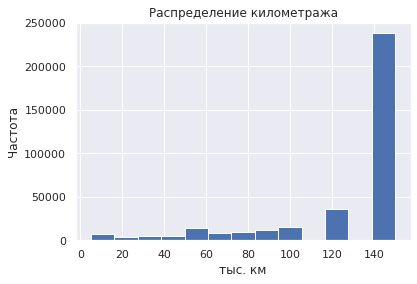

In [33]:
(imputed_data['Kilometer'] / 1000).plot(kind = 'hist', bins = 13)
plt.xlabel('тыс. км')
plt.ylabel('Частота')
plt.title('Распределение километража');

Обнаруживаем ещё одну проблему: очень много максимальных значений 150 тыс. км. Среднестатистический автомобиль проезжает около 15 тыс. км в год. Получается у нас большинство автомобилей возрастом около 10 лет.   
Скорее всего возникла ошибка при создании датасета. При обучении наших моделей такой столбец будет ухудшать их работу, а значит скорее всего его придется удалить.

`Price`

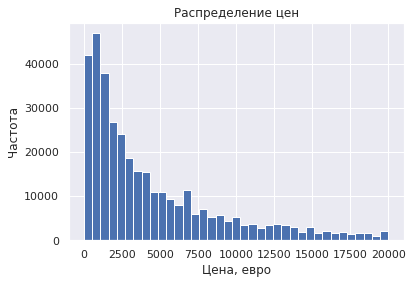

In [34]:
imputed_data['Price'].plot(kind = 'hist', bins = 37);
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.title('Распределение цен');

Распределение похоже на распределения Пуассона - видим пик значений около 1500 евро и длинный хвост справа.

`Power`

Разберем нулевые значения в этом столбце и посмотрим на распределение признака.

In [35]:
imputed_data['Power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

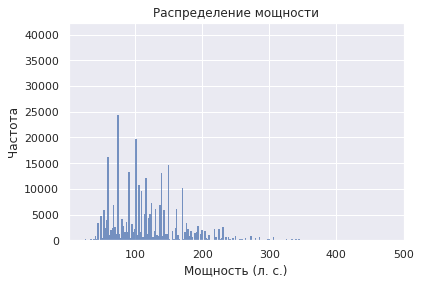

In [36]:
g = sns.histplot(data=imputed_data, x="Power") 

plt.xlim(1, 500)
plt.xlabel('Мощность (л. с.)')
plt.ylabel('Частота')
plt.title('Распределение мощности');

Посмотрим сколько у нас нулевых значений:

In [37]:
imputed_data[imputed_data['Power'] == 0]['Power'].count()

40225

Их действительно много. Почему могут возникать нулевые значения?  
Первый вариант: люди таким образом указывают то что автомобиль не на ходу.  
Второй вариант: пропущенные значения в датасете были заполнены нулями.  
Могут быть и другие варианты, однако неоднозначность в объяснении склоняет нас к тому, что эти значения не могут быть восстановлены или заменены на другие и их придется удалить.

In [38]:
imputed_data.drop(imputed_data[imputed_data['Power'] == 0].index, axis=0, inplace = True)
imputed_data.shape

(314140, 11)

На 2021 год самая мощная машина в мире имеет около 2012 лошадиных сил. Вполне возможно что люди иногда продают суперкары, однако все что выше этого значания можно считать выбросами и также удалить. 

In [39]:
imputed_data[imputed_data['Power'] > 2012]['Power'].count()

116

In [40]:
imputed_data.drop(imputed_data[imputed_data['Power'] > 2012].index, axis=0, inplace = True)
imputed_data.shape

(314024, 11)

### Оценка корреляции признаков.

Для категориальных признаков воспользуемся коэффициентом коррелияции V Крамера. Количественная переменная у нас только `Power`, так как километры в нашем датасете представлены как категории.

In [41]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

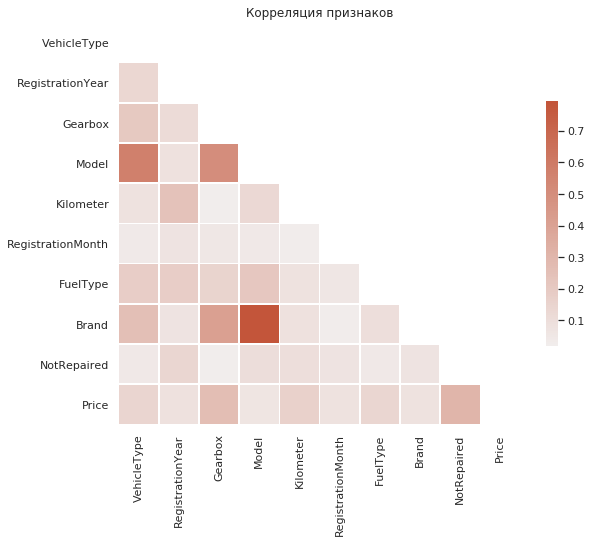

In [42]:
sns.set_theme(style="white")

#Вычислим матрицу кореляции
corr = imputed_data.drop(['Power'], axis = 1).corr(method=cramers_v)

#Зададим маску
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(9, 9))

#Зададим colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title(f'Корреляция признаков');

Видим что самая большая корреляция присутствует у `Brand` и `Model`, а также, как мы и ожидали, обнаруживается корреляция между `VehicleType` и `Model`.

In [43]:
corr['Brand']['Model']

0.7935614185274869

In [44]:
corr['VehicleType']['Model']

0.5708330853626837

Коэффициент корреляции V Крамера может принимать знчения от 0 до 1. 0.79 это довольно большое значение. К тому же признак Модель `Model` попарно коррелирует с двумя другими. Для борьбы с мультиколлинеарностью можно либо удалять один из признаков, либо добавлять в модели регуляризяцию. 
Удалим признак `Model` и посмотрим на работу моделей.

In [45]:
imputed_data.drop(['Model'], axis = 1, inplace = True)

### Вывод

На данном этапе мы проводили исследовательский анализ данных.  
2.1 В начале были рассмотрены распределения признаков и проведена оценка аномальных значений.

- `Kilometer`: Обнаруживаем ещё одну проблему: очень много максимальных значений 150 тыс. км. Среднестатистический автомобиль проезжает около 15 тыс. км в год. Получается у нас большинство автомобилей возрастом около 10 лет.
Скорее всего возникла ошибка при создании датасета. При обучении наших моделей такой столбец будет ухудшать их работу.

- `Price`: Распределение похоже на распределения Пуассона – наблюдался пик значений около 1500 евро и длинный хвост справа.

- `Power`: Количество нулевых значений: 40225  
    Почему могут возникать нулевые значения?  
    Первый вариант: люди таким образом указывают то что автомобиль не на ходу.  
    Второй вариант: пропущенные значения в датасете были заполнены нулями.  
    Могут быть и другие варианты, однако неоднозначность в объяснении склоняет нас к тому, что эти значения не могут быть восстановлены или заменены на другие и их придется удалить.

    На 2021 год самая мощная машина в мире имеет около 2012 лошадиных сил. Вполне возможно что люди иногда продают суперкары, однако все что выше этого значания мы считали выбросами (116 объявлений) и удаляли. 

2.2 Была проведена оценка корреляции признаков.  
Для категориальных признаков мы использовали коэффициент коррелияции V Крамера. 

Самая большая корреляция наблюдалась у `Brand` и `Model` (0.79), а также, как мы и ожидали, обнаруживается корреляция между `VehicleType` и `Model` (0.57).

Коэффициент корреляции V Крамера может принимать знчения от 0 до 1. 0.79 это довольно большое значение. К тому же признак Модель попарно коррелирует с двумя другими. На данном этапе мы решили удалить признак `Model` и оценить на работу моделей.

## Построение моделей  

### Выбор метрики для оценки качества моделей.  

Для оценки моделей на этапе обучений будем использовать метрику RMSE. Она легко считается, а также придаёт больший вес большим ошибкам.  
На этапе анализа моделей можно добавить MAE для лучшей интерпретируемости оценки.

### Обучение моделей и оценка их качества кросс-валидацией. 

Зададим признаки `features` и целевой признак `target`:

In [46]:
features = imputed_data.drop(['Price'], axis = 1)
target = imputed_data['Price']

features.shape, target.shape

((314024, 9), (314024,))

Поскольку у нас нет тестовой выборки, зададим её сами. Для того, чтобы получить из данных как можно больше информации, делить выборки будем в соотношении 4:1. 

In [47]:
#разделим выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2,      
                                                                              random_state=RS)

In [48]:
#категориальные признаки
categorical_features = features.drop(['Power'], axis = 1).columns.tolist()

In [49]:
#расчет RMSE
def rmse(validation, predictions):
    return mse(validation, predictions) ** 0.5

### Light GBM

In [51]:
%%time
model = lgb.LGBMRegressor(objective='regression', num_round = 100, random_state=RS)

grid_params = {
             'learning_rate': [0.005, 0.01], #рейт обучения
             'num_leaves': range(10, 71, 20),  #макс. количество листьев
             'min_child_samples': [10, 20, 30], #минимальный размер для нового листа
             'max_depth': range(10, 201, 50), #максимальная глубина дерева
             }
        
grid = RandomizedSearchCV(model, grid_params, 
                    cv=5, n_jobs = -1, 
                    n_iter=7,
                    scoring = make_scorer(rmse, greater_is_better=False), 
                    verbose=1)

grid.fit(features_train, target_train, 
         categorical_feature = categorical_features
        )

print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best_params: {'num_leaves': 70, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01}
best_score: -2579.2203959204935
CPU times: user 9min 43s, sys: 3.54 s, total: 9min 47s
Wall time: 9min 53s


Лучшие параметры: {'num_leaves': 70, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01}  
Лучший RMSE: 2579.22

### RandomForestRegressor

In [52]:
%%time
model = RandomForestRegressor(random_state = RS)
parameters = {'n_estimators': range (10, 31, 20),
              'max_depth': range (1, 12, 5),
              }

grid = GridSearchCV(model, parameters, cv=5, n_jobs = -1, 
                    scoring = make_scorer(rmse, greater_is_better=False), 
                    verbose = 0)

grid.fit(features_train, target_train)

print('best_params:', grid.best_params_)
print('best_score:', grid.best_score_)

best_params: {'max_depth': 11, 'n_estimators': 30}
best_score: -1947.9425018017585
CPU times: user 2min 12s, sys: 0 ns, total: 2min 12s
Wall time: 2min 12s


Лучшие параметры: {'max_depth': 11, 'n_estimators': 30}  
Лучший RMSE: 1947.94

Как видим, простая модель случайного леса показывает лучшие результаты чем LGBM. 
На этапе анализа моделей можно добавить MAE для лучшей интерпретируемости оценки. 

В теории можно было бы ещё попробовать использовать линейную регрессию, однако для этого необходимо перекодировать категориальные признаки в one hot encoding, а также нормализовать количественные признаки.

### Вывод

Этот этап был посвящен обучению моделей.  

3.1. Мы выбрали метрики для оценки качества моделей.  
Для оценки моделей на этапе обучений мы решили использовать метрику RMSE, поскольку она легко считается, а также придаёт больший вес большим ошибкам. Также, для лучшей интерпретируемости оценки, мы решили добавить MAE на этап анализа моделей.

3.2. Обучали модели и оценивали их качество кросс-валидацией.
Случайным образом, в соотношении 4:1, создали тестовую выборку. 

3.3. Рассмотрели работу модели Light GBM

    Wall time поиска лучшей модели: 9min 53s  
    Лучшие параметры: {'num_leaves': 70, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01}  
    Лучший RMSE: 2579.22  

3.4. RandomForestRegressor

    Wall time поиска лучшей модели: 2min 12s  
    Лучшие параметры: {'max_depth': 11, 'n_estimators': 30}  
    Лучший RMSE: 1947.94

Модель случайного леса показывала лучшие результаты чем LGBM, однако для дальнейшего анализа мы взяли обе модели. 

## Анализ моделей

### Проверка моделей на тестовой выборке

`LGBMRegressor`

In [75]:
%%time

model = lgb.LGBMRegressor(objective='regression', 
                          num_round = 100, 
                          learning_rate= 0.01, 
                          num_leaves= 70,  
                          min_child_samples= 30,
                          max_depth= 10,
                          random_state=RS)

model.fit(features_train, target_train, 
         categorical_feature = categorical_features
        )
;  

CPU times: user 21 s, sys: 159 ms, total: 21.1 s
Wall time: 21.5 s


''

In [76]:
%%time
precictions = model.predict(features_test)     

CPU times: user 1.79 s, sys: 5.48 ms, total: 1.8 s
Wall time: 1.8 s


In [77]:
test_rmse = rmse(target_test, precictions)
test_mae = mae(target_test, precictions)
print('RMSE на тестовой выборке: {:.2f}'.format(test_rmse))
print('MAE на тестовой выборке: {:.2f}'.format(test_mae))

RMSE на тестовой выборке: 2584.71
MAE на тестовой выборке: 1886.49


`RandomForestRegressor`

In [78]:
%%time

model = RandomForestRegressor(random_state = RS,
                              max_depth= 11, 
                              n_estimators= 30
                              )

model.fit(features_train, target_train)
;

CPU times: user 12.6 s, sys: 0 ns, total: 12.6 s
Wall time: 12.8 s


''

In [79]:
%%time
precictions = model.predict(features_test)

CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 279 ms


In [80]:
test_rmse = rmse(target_test, precictions)
test_mae = mae(target_test, precictions)
print('RMSE на тестовой выборке: {:.2f}'.format(test_rmse))
print('MAE на тестовой выборке: {:.2f}'.format(test_mae))

RMSE на тестовой выборке: 1959.02
MAE на тестовой выборке: 1237.97


### Проверка моделей на адеватность

In [81]:
dummy_model = DummyRegressor(strategy = 'median')
dummy_model.fit(features_train, target_train)
dummy_model_predictions = dummy_model.predict(features_test)

dummy_rmse = rmse(target_test, dummy_model_predictions)
dummy_mae = mae(target_test, dummy_model_predictions)
print('RMSE dummmy модели: {:.2f}'.format(dummy_rmse))
print('MAE dummmy модели: {:.2f}'.format(dummy_mae))

RMSE dummmy модели: 4881.56
MAE dummmy модели: 3360.31


Итоговая RMSE dummy модели, не использующей машинное обучение, составила 4881.56. Как видим, наши модели построены не зря – они имеют большую точность (около 1959 у случайного леса).

### Сравнение характеристик моделей: скорость работы и качество предсказаний

Запишем результаты работы наших моделей:

Модель | Время обучения | Время предсказания | **RMSE** | **MAE**
:---|---|---|---|---
**Light GBM** | 21.5 c | 1.8 с | 2584.71 | 1886.49
**Случайный лес** | 12.8 c | 0.28 с | 1959.02 | 1237.97

Как видим, по всем параметрам модель случайного леса работает лучше Light GBM. Её средняя абсолютная ошибка равняется 1237.97.
Случайный лес сделал предсказания для ≈ 60 тысяч объявлений за 300 милисекунд. 

Самая главная проблема – ошибка в ≈ тысячу двести евро это довольно плохой результат с точки зрения бизнеса, ведь клиенты хотят узнать максимально точную оценку для своего автомобиля. Для того, чтобы улучшить предсказания необходимо разобраться с первоначальными данными. 
В первую очередь: получить реальные значения километража, понять откуда появляются нулевые значения в столбце с мощностью. 

### Вывод

На данном этапе мы провели анализ построенных моделей.

4.1. Модели были проверены на тестовой выборке, для каждой были оценены время работы и точность их предсказаний.

4.2. Потом мы проверили модели на адеватность  

Итоговая RMSE dummy модели, не использующей машинное обучение, составила 4881.56. Как оказалось, наши модели были построены не зря – они имеют большую точность (около 1959 у модели случайного леса).

4.3.  Сравнение характеристик моделей: скорость работы и качество предсказаний
Результаты работы наших моделей:

Модель | Время обучения | Время предсказания | **RMSE** | **MAE**
:---|---|---|---|---
**Light GBM** | 21.5 c | 1.8 с | 2584.71 | 1886.49
**Случайный лес** | 12.8 c | 0.28 с | 1959.02 | 1237.97

Как видим, по всем параметрам модель случайного леса работает лучше Light GBM. Её средняя абсолютная ошибка равняется 1237.97. Случайный лес сделал предсказания для ≈ 60 тысяч объявлений за 300 милисекунд.

Самая главная проблема – ошибка в примерно тысячу двести евро это довольно плохой результат с точки зрения бизнеса, ведь клиенты хотят узнать максимально точную оценку для своего автомобиля. Для того, чтобы улучшить предсказания необходимо разобраться с первоначальными данными. В первую очередь, для этого нужно получить реальные значения километража, а также понять, откуда появляются нулевые значения в столбце с мощностью.

## Общий вывод

**1.** На первом этапе мы подготовили данные к дальнейшему анализу.

В изначальных данных мы получили информацию о 354369 объявлениях. В 5и строках наблюдались пропуски. 

1.2 Была проведена предобработка данных:  

1.2.1. Мы нашли и удалили дубликаты

1.2.2. Был выбран метод кодировки признаков  
Было решено использовать Ordinal encoding.  
Также на данном этапе были обнаружены проблемы в признаках `RegistrationMonth`, `Kilometer`, `FuelType`, `NumberOfPictures`. 

1.2.3. Далее мы проанализировали значения "проблемных" признаков

    RegistrationMonth: Появляется нулевой месяц. В целом, 0 появляются примерно также как и остальные месяца. 
    Есть два возможных объяснения: 
    1. Этот признак сформирован автоматически, при его формировании случайно добавили "нулевой месяц"; 
    2. Так записывали пропущенные значения. Поскольку признаки категориальные, можем оставить все как есть, работу моделей это не изменит, информацию можно будет получить.
    FuelType: Был проверен и одобрен список уникальных значений.
    NumberOfPictures: Этот признак состоял только из нулей. Скорее всего эти данные были потеряны при формировании датасета. Поскольку эти данные мы восстановить никак не можем, признак был удален.

1.2.4. Ordinal encoding  
После создания списка категориальных переменных мы их закодировали.

1.2.5.  Обработка пропусков  
Заполнение пропусков было проведено с помощью KNNImputer, который заполняет значения по n ближайшим соседям. Алгоритм реализовывался batch-ами, которые разделяли выборку на несколько подвыборок. Заполнение мы оценивали по признаку `NotRepaired`, где самое большое количество пропусков и признаку `FuelType`. После оценки мы пришли к выводу, что заполнение было проведено успешно.

**2.** На данном этапе мы проводили исследовательский анализ данных.  
2.1 В начале были рассмотрены распределения признаков и проведена оценка аномальных значений.

- `Kilometer`: Обнаруживаем ещё одну проблему: очень много максимальных значений 150 тыс. км. Среднестатистический автомобиль проезжает около 15 тыс. км в год. Получается у нас большинство автомобилей возрастом около 10 лет.
Скорее всего возникла ошибка при создании датасета, это потенциально проблемное место.

- `Price`: Распределение похоже на распределения Пуассона – наблюдался пик значений около 1500 евро и длинный хвост справа.

- `Power`: Было обнаружено большое количество нулевых значений (40225). Почему могут возникать нулевые значения?  
    Первый вариант: люди таким образом указывают то что автомобиль не на ходу.  
    Второй вариант: пропущенные значения в датасете были заполнены нулями.  
    Могут быть и другие варианты, однако неоднозначность в объяснении склоняет нас к тому, что эти значения не могут быть восстановлены или заменены на другие и их придется удалить. Также были удалены слишком большие значения. 

2.2 Была проведена оценка корреляции признаков.  
Для категориальных признаков мы использовали коэффициент коррелияции V Крамера. 

Самая большая корреляция наблюдалась у `Brand` и `Model` (0.79), а также, как мы и ожидали, обнаруживается корреляция между `VehicleType` и `Model` (0.57). На данном этапе мы решили удалить признак `Model`.

**3.** Третий этап был посвящен обучению моделей.  

3.1. Мы выбрали метрики для оценки качества моделей.  
Для оценки моделей на этапе обучений мы решили использовать метрику RMSE, поскольку она легко считается, а также придаёт больший вес большим ошибкам. Также, для лучшей интерпретируемости оценки, мы решили добавить MAE на этап анализа моделей.

3.2. Обучали модели и оценивали их качество кросс-валидацией.
Случайным образом, в соотношении 4:1, создали тестовую выборку. 

3.3. Рассмотрели работу модели Light GBM

    Wall time поиска лучшей модели: 9min 53s  
    Лучшие параметры: {'num_leaves': 70, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01}  
    Лучший RMSE: 2579.22  

3.4. Модель RandomForestRegressor

    Wall time поиска лучшей модели: 2min 12s  
    Лучшие параметры: {'max_depth': 11, 'n_estimators': 30}  
    Лучший RMSE: 1947.94

Модель случайного леса показывала лучшие результаты чем LGBM, однако для дальнейшего анализа мы взяли обе модели. 

**4.** На последнем этапе мы провели анализ построенных моделей.

4.1. Модели были проверены на тестовой выборке, для каждой были оценены время работы и точность их предсказаний.

4.2. Все модели были проверены на адеватность  

Итоговая RMSE dummy модели, не использующей машинное обучение, составила 4881.56. Как оказалось, наши модели были построены не зря – они имеют большую точность (около 1959 у модели случайного леса).

4.3.  Сравнение характеристик моделей: скорость работы и качество предсказаний
Результаты работы наших моделей:

Модель | Время обучения | Время предсказания | **RMSE** | **MAE**
:---|---|---|---|---
**Light GBM** | 21.5 c | 1.8 с | 2584.71 | 1886.49
**Случайный лес** | 12.8 c | 0.28 с | 1959.02 | 1237.97

Как видим, по всем параметрам модель случайного леса работает лучше Light GBM. Её средняя абсолютная ошибка равняется 1237.97. Случайный лес сделал предсказания для ≈ 60 тысяч объявлений за 300 милисекунд.

Самая главная проблема – ошибка примерно в 1200 евро у лучшей модели. Это довольно плохой результат с точки зрения бизнеса, ведь клиенты хотят узнать максимально точную оценку для своего автомобиля. Для того, чтобы улучшить предсказания необходимо разобраться с первоначальными данными. В первую очередь, для этого нужно получить реальные значения километража, а также понять, откуда появляются нулевые значения в столбце с мощностью.